# Summary of Findings

### Introduction
Prediction: We will try to predict the reach, or the number of views, of an ad. 

This is a regression problem. 

The target variable is "Impressions" because we want to see how many people watched a particular ad or not, and the higher number of impressions means the more reach it has. This is the best column to choose for our predition problem. 

We are using accuracy as our objective since we are dealing with predicting a quantitative number (views). To do this, we chose to use r-squared as our evaluation metric because we are using regression in our model. We ran our models multiple times because it varies a lot, so to get a more accurate evaluation metric, we took the mean of all the r-squares we got in our trials.

### Baseline Model
In this baseline model, we use all the features from the original dataset except 'Targeting Connection Type', "Targeting Carrier (ISP)" because they did not have any values at all. We also did not include "Impressions" in our training model because that is our target variable. Therefore, there were 24 features. There were 23 categorical features and 1 quantitative feature.

OneHotEncoder is ideal, because we use easily use it on all of the categorical columns. The function of OHE is to "Encode categorical features as a one-hot numeric array", so we can have numerical values onto the qualitiative values for easy calculations and predictions within the data. For both numerical and categorical columns, we used Simple Imputer in case there were any missing values that we had missed. 

Since it is just a baseline model, we did not focus on separating between nominal or ordinal columns because we end up dropping a lot of the columns later in our final model. But we don't differentiate it in our final model either, because we only use either quantitative or nominal data. 

r-squared mean: -5.158904576734167e+16

Based on the evaluation metric as well as referencing our pipeline, we anticipate the baseline model to not be a very good predictor of the number of views. The OHE wthin the categorical columns is decent, but it does not do anything within the quantitative columns except impute it with a neutral value of 0, which can possibly bias the columns in the direction that we don't want to go in. 

### Final Model
Impressions, Duration, and Spend are our quantitative columns. StartDate, EndDate, Gender, CountryCode, and spending_brackets are our qualitative columns, but more specifically, our nominal data. We are not working with any ordinal data. Although StartDate and EndDate may be a bit blurry on the classification of being nominal or ordinal, we have categorized these two columns as nominal, which is explained in a bit more detail later. We chose to work with these columns specifically because we considered these to contain the most valuable information. StartDate and EndDate might be significant, concerning the exact time of year that the ad was being displayed. For example, if it was aired durig the holiday season, there might be more impressions because more people are out of school, on vacation and not working, etc. As for gender, if there were restrictions on one gender, it cuts off half the general population, which will likely greatly reduce the amount of views an ad has. For CountryCode, there are vastly different population numbers varying by country. The US may have way more impressions than a smaller and less populated country, like Korea for example. It also brings into context that many people around the world may not utilize Snapchat as one of their main sources of social media- in other words, Snapchat may not be as popular in other countries as it is in the United States. 

We created a new feature, Duration, which is the time in hours, the ad was aired on Snapchat. We categorized StartDate and EndDate as nominal categories, as we believe it represents no ordering. But by being able to subtract the EndDate and the StartDate, we can develop values that do have specific orderings to them; e.g. ads that aired for 5 hours is definitely shorter than ones that aired for 25 hours. But this new column, Duration, is a good addition to our features because it is a quantitative column as it is numbers that we can do mathematical applications with, e.g. mean, median, quartiles, etc. 

We created a new feature called spending_brackets. This is a binary column, in which we have categorized what a 'high' or 'low' spending is. We were able to define this threshold by graphing the distribution (the histogram above). By having a feature with a more definitive answer on what we consider a high or low spending value, we believe this will enhance our predictions. 

In addition to the functions that we used within our baseline model, we also included PCA onto our categorical columns as well as QuantileTransformer within our numerical columns. 
PCA is significant in increasing our accuracy of our predictions because it is able to project the values within the categorical columns into a lower dimensional space if needed by using Singular Value Decomposition (SVD). This can be especially important, especially to centralize the values coming from the categorical columns, even if we ourselves may not necessarily see it. As for QuantileTransformer, it allows the numerical columns to follow a bell curved shape. 

We had set our baseline to a LinearRegression model, but later progressed to using a RandomForestRegressor because we thought that this would work better than a LinearRegression model because it is able to use the averages of our features to be able to produce better predictions. Another plus is that it is able to control, to some extent, over-fitting, which was an issue we were worried about. 

r-squared mean: 0.6829500204478698

The parameter that ended up performing the best was the high or low spending feature that we newly engineered. It gave us a r-squared of 0.7858. Our newly engineered feature duration also performed very well, it gave us a r-squared of 0.75247.

### Fairness Evaluation
To evaluate the fairness of our final model, we decided to see if our model is more favorable towards high or low impressions. To measure how well our model is performing for either high or low impressions, we chose the measure of RMSE. This gives us a good measure of how far our prediction is from the actual observed data. 

Null hypothesis: Our final model predicts high and low impressions at an equal accuracy.

Alternative hypothesis: Our final model predicts low impressions better than high impressions.

To test our null hypothesis we will be using RMSE as the test statistic and we will set our significance value to 0.05.

The p-value we got from running 25 trials is 0. This means that in 25 trials, the model is predicting low impressions better than it is high impressions in all trials. Therefore, we reject our null hypothesis and our model may not be fair and is favorable towards predicting low impressions.

# Code

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
import re
from sklearn import metrics
import datetime as dt 
from sklearn.preprocessing import QuantileTransformer


In [39]:
eighteen = pd.read_csv("2018.csv")
nineteen = pd.read_csv("2019.csv")
result = pd.concat([eighteen, nineteen])
result = result.reset_index(drop=True)
dates = result[['StartDate', 'EndDate', 'CreativeUrl']]
dates['StartDate'] = dates['StartDate'].str[:-1]
dates['EndDate'] = dates['EndDate'].str[:-1]
# result.columns

/Users/cindy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/cindy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


### Baseline Model

In [40]:
# changing all dates to datetime objects
result['StartDate'] = result['StartDate'].str[:-1]
result['EndDate'] = result['EndDate'].str[:-1]

# Segments
result['Segments'] = result['Segments'].fillna("Not Provided by Advertiser")

# these cols need to all be filled nans with the respective country
country_cols = ["RegionID", "ElectoralDistrictID","LatLongRad","MetroID","Targeting Geo - Postal Code"]

for i in range(len(country_cols)):
    result[country_cols[i]] = result[country_cols[i]].fillna(result["CountryCode"])

# these cols need to all be filled nans with just string "all"
all_cols = ["Interests","Language","AdvancedDemographics","Gender","AgeBracket","OsType"]
    
for i in range(len(all_cols)):
    result[all_cols[i]] = result[all_cols[i]].fillna("All")
    
nan_cols = ['CandidateBallotInformation', 'LocationType', 'CreativeProperties']
for i in range(len(nan_cols)): 
    result[nan_cols[i]] = result[nan_cols[i]].fillna("Not provided")
    
# EndDate                         fill with "Present" or current time
result['EndDate'] = str(result['EndDate'].fillna(datetime.utcnow()))
# Gender                          fill with "All"
result['Gender'] = result['Gender'].fillna("All")
result = result.drop(columns=['Targeting Connection Type', "Targeting Carrier (ISP)"])
#CandidateBallotInformation; LocationType; Creative Properties

In [54]:
X = result.drop(['Impressions'], axis=1)
y = result.Impressions

In [57]:
#Dividing categorical and numerical columns
types = X.dtypes
catcols = types.loc[types == np.object].index
numcols = types.loc[types != np.object].index

#pipeline for categorical columns
cats = Pipeline([('numcols', SimpleImputer(strategy='constant', fill_value="null")),
                 ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))
                 ])

ct = ColumnTransformer([
    ('catcols', cats, catcols),
    ('numcols', SimpleImputer(strategy='constant', fill_value=0), numcols) #pipeline for numerical columns 
])

pl = Pipeline([('feats', ct), ('reg', LinearRegression())])

#getting the mean of rmse and r^2 after 50 iterations 
rmse_list = []
rsquared_list = []
for i in range(10): 
    X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.25)
    pl.fit(X_tr, y_tr)
    rsquared = pl.score(X_ts, y_ts)
    rsquared_list.append(rsquared)
    preds = pl.predict(X_ts)
    rmse = np.sqrt(np.mean(preds - y_ts)**2)
    rmse_list.append(rmse)
print("rmse mean: " + str(np.mean(rmse_list)))
print("r-squared mean: " + str(np.mean(rsquared_list)))

rmse mean: 49126644455706.836
r-squared mean: -5.158904576734167e+16


### Final Model

#### New Feature: Duration

In [66]:
#setting StartDate and EndDate to datetime objects so we can calculate a new feature, Duration 
dates['StartDate'] = pd.to_datetime(dates['StartDate'])
dates['EndDate'] = pd.to_datetime(dates['EndDate'], errors='coerce')
dates['EndDate'] = dates['EndDate'].fillna(datetime.utcnow())

In [67]:
#New feature: Duration 
result['Duration'] = abs(dates['EndDate'] - dates['StartDate'])
result["Duration"] = round(result['Duration'].apply(lambda x: x.days * 24 + x.seconds // 3600))

In [68]:
#the columns we're working with 
result = result[['Impressions', 'StartDate', 'EndDate', 'Duration', 'Spend', 'Gender', 'CountryCode']]

#Dividing categorical and numerical columns
types = X.dtypes
catcols = types.loc[types == np.object].index
numcols = types.loc[types != np.object].index

#pipeline for categorical columns
cats = Pipeline([
    ('imp', SimpleImputer(strategy='constant', fill_value='NULL')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False)),
    ('pca', PCA(svd_solver='full', n_components=0.99))
])

ct = ColumnTransformer([
    ('catcols', cats, catcols),
    #pipeline for numerical columns
    ('numcols', SimpleImputer(strategy='constant', fill_value=0), numcols),
    ('quantiles', QuantileTransformer(), numcols)

])

pl2 = Pipeline([('feats', ct), ('reg', RandomForestRegressor())])

X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.25)
pl2.fit(X_tr, y_tr)
rsquared = pl2.score(X_ts, y_ts)
print("r-squared: " + str(rsquared))
preds = pl2.predict(X_ts)

/Users/cindy/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


r-squared: 0.7524728254515556


#### New Feature: High or Low Spending

In [69]:
result['Spend'].max()

85000

Text(0.5, 0, 'Spend')

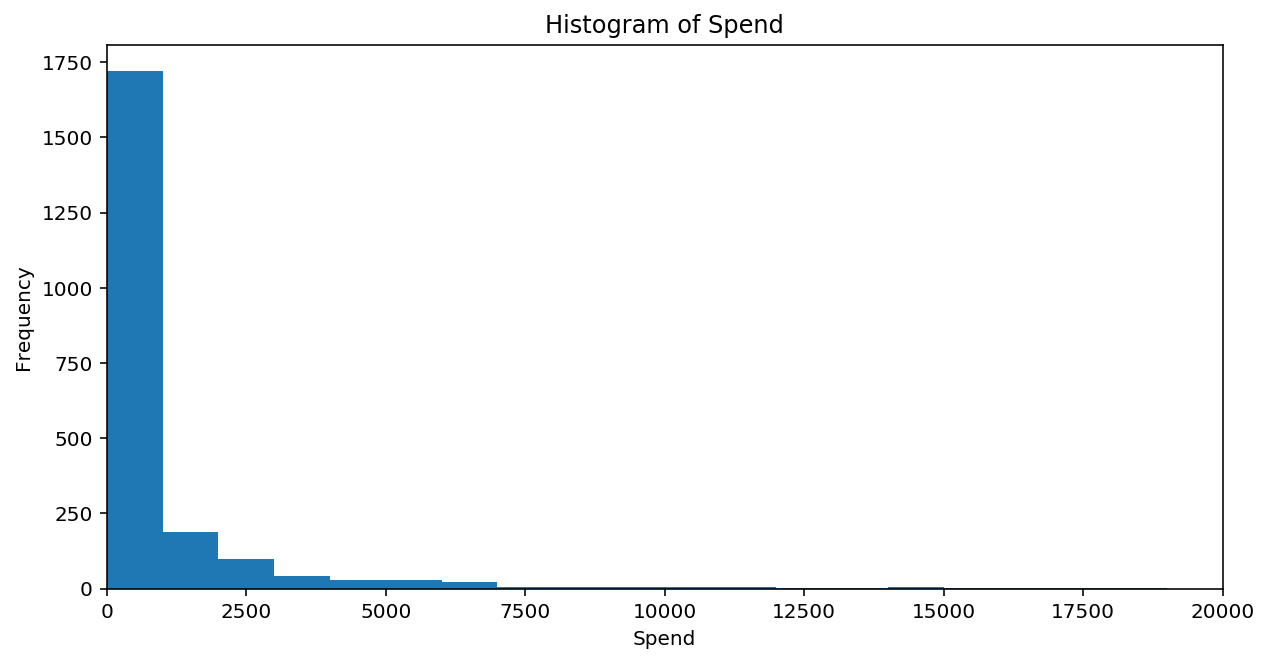

In [81]:
result["Spend"].plot(kind='hist', bins=85,figsize=(10,5), xlim=(0,20000))
plt.title('Histogram of Spend')
plt.xlabel('Spend')

We can tell that 1000 is where a majority of the ad spending is concentrated on because we have set the number of bins to 85, and since the max amount spent on an ad is 85,000, we know that each bin is roughly at around 1,000. So, we decided to make the cutoff for high and low spending to be at $1000. 

In [71]:
#New feature: High or low spending 
result['spending_brackets'] = (result.Spend <= 1000).replace({True:'Low', False:'High'})

In [74]:
#columns we're working with 
result = result[['Impressions', 'StartDate', 'EndDate', 'spending_brackets', 'Spend','Gender', 'CountryCode']]

#Dividing categorical and numerical columns
types = X.dtypes
catcols = types.loc[types == np.object].index
numcols = types.loc[types != np.object].index

#pipeline for categorical columns
cats = Pipeline([
    ('imp', SimpleImputer(strategy='constant', fill_value='NULL')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False)),
    ('pca', PCA(svd_solver='full', n_components=0.99))
])

ct = ColumnTransformer([
    ('catcols', cats, catcols),
    #pipeline for numerical columns
    ('numcols', SimpleImputer(strategy='constant', fill_value=0), numcols),
    ('quantiles', QuantileTransformer(), numcols)

])

pl2 = Pipeline([('feats', ct), ('reg', RandomForestRegressor())])

X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.25)
pl2.fit(X_tr, y_tr)
rsquared = pl2.score(X_ts, y_ts)
print("r-squared: " + str(rsquared))
preds = pl2.predict(X_ts)

/Users/cindy/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


r-squared: 0.7858077276567208


#### Final Model with All New Features

In [75]:
#New feature: Duration 
result['Duration'] = abs(dates['EndDate'] - dates['StartDate'])
result["Duration"] = round(result['Duration'].apply(lambda x: x.days * 24 + x.seconds // 3600))

#New feature: Media Type
result['spending_brackets'] = (result.Spend <= 1000).replace({True:'Low', False:'High'})

In [78]:
#columns we're working with 
result = result[['Impressions', 'StartDate', 'EndDate', 'Duration', 'spending_brackets', 'Spend','Gender', 'CountryCode']]

#Dividing categorical and numerical columns
types = X.dtypes
catcols = types.loc[types == np.object].index
numcols = types.loc[types != np.object].index

#pipeline for categorical columns
cats = Pipeline([
    ('imp', SimpleImputer(strategy='constant', fill_value='NULL')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False)),
    ('pca', PCA(svd_solver='full', n_components=0.99))
])

ct = ColumnTransformer([
    ('catcols', cats, catcols),
    #pipeline for numerical columns
    ('numcols', SimpleImputer(strategy='constant', fill_value=0), numcols),
    ('quantiles', QuantileTransformer(), numcols)

])

pl2 = Pipeline([('feats', ct), ('reg', RandomForestRegressor())])

rmse_list = []
rsquared_list = []
for i in range(10): 
    X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.25)
    pl2.fit(X_tr, y_tr)
    rsquared = pl2.score(X_ts, y_ts)
    rsquared_list.append(rsquared)
    preds = pl2.predict(X_ts)
    rmse = np.sqrt(np.mean(preds - y_ts)**2)
    rmse_list.append(rmse)
print("r-squared mean: " + str(np.mean(rsquared_list)))

/Users/cindy/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


r-squared mean: 0.6829500204478698


### Fairness Evaluation

#### Finding threshold for categorizing impressions as high or low reach

Text(0.5, 0, 'Impressions')

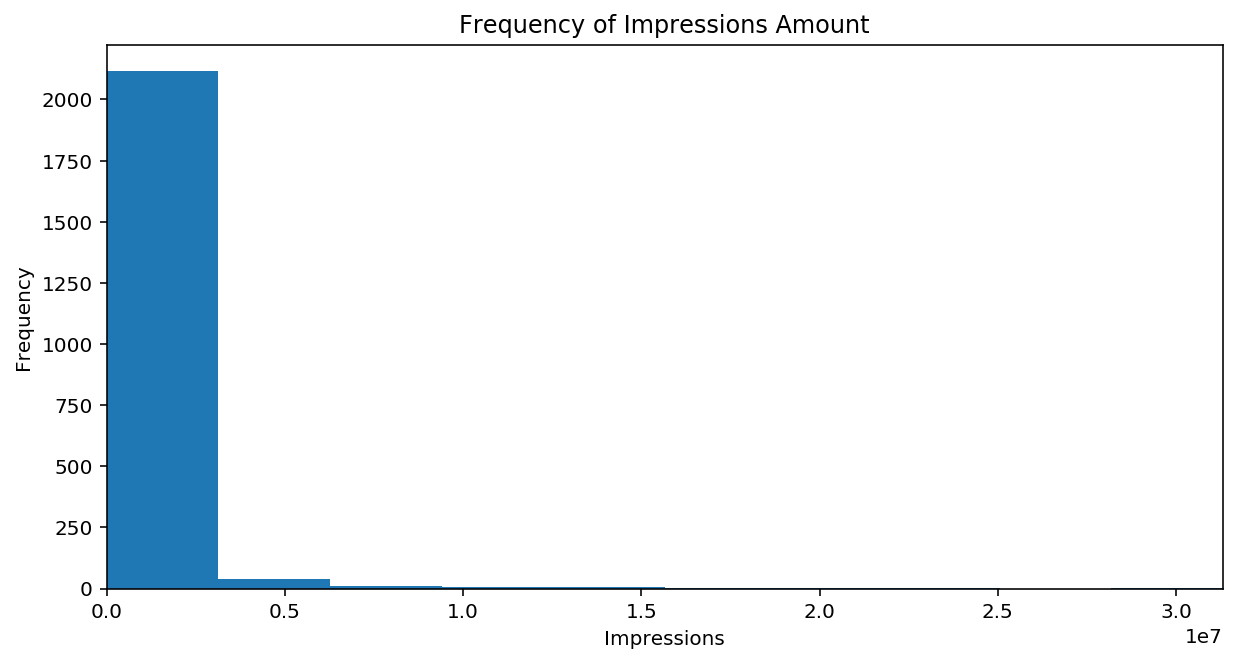

In [79]:
x = result["Impressions"].plot(kind="hist", figsize=(10,5), bins=10, xlim=(0, result["Impressions"].max()))
plt.title('Frequency of Impressions Amount')
plt.xlabel('Impressions')

After graphing this, we noticed that there is a huge difference in this sharp contrast of impressions. So from there, we looked at the data and saw that there was a sharp contrast between the first bin and second bin. There, we made a estimate that 3130994.5 was the cutoff for low/high reach. 3130994.5 would be the first value that would be classified as a 'high' reach.

#### Permutation Testing

Null hypothesis: Our final model predicts high and low impressions at an equal accuracy.

Alternative hypothesis: Our final model predicts low impressions better than high impressions.

To test our null hypothesis we will be using RMSE as the test statistic and we will set our significance value to 0.05.

In [85]:
low_list = []
high_list = []

for i in range(25):
    # splitting and training data using our final model
    X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.25)
    pl2.fit(X_tr, y_tr)
    preds = pl2.predict(X_ts)

    # putting the predictions, observed, and categorizing if our impressions is
    # high or low into a simple dataframe
    results = pd.DataFrame()
    results["Observed"] = y_ts
    results["Prediction"] = preds
    results['High_or_Low'] = (results.Observed <= 3130994.5).replace({True:'Low', False:'High'})
    results = results[["High_or_Low", "Observed", "Prediction"]]

    #calculate the rmse of the high impressions
    high_df = results[results["High_or_Low"] == "High"]
    high_rmse = np.sqrt(np.mean(high_df["Prediction"] - high_df["Observed"])**2)
    high_list.append(high_rmse)

    #calculate the rmse of the low impression
    low_df = results[results["High_or_Low"] == "Low"]
    low_rmse = np.sqrt(np.mean(low_df["Prediction"] - low_df["Observed"])**2)
    low_list.append(low_rmse)

#calculate how many times low performs better than high
pvalue = np.count_nonzero(low_list >= high_list) / 25 # count how many times the low list does better than the high

In [86]:
pvalue

0.0

Our p-value is 0, which means that in 25 trials, the model is predicting better low impressions than it is high impressions in all trials. Therefore, we reject our null hypothesis and our model may not be fair and is favorable towards predicting low impressions.